# Pertanyaan penelitian

Pada kesempatan kali ini, saya ingin mengetahui bagaimana perkembangan kasus baru pada tanggal 1 - 14 Des 2021 di Indonesia. Jika diasumsikan tidak adanya outbreak mendadak dan masuknya varian baru apakah kasusnya bisa menurun dan sejauh apa menurunnya.

Data yang diolah adalah data Covid-19 di Indonesia yang diambil dari situs kawalcovid19. Data diambil dari tanggal 1 Mei 2021 - 30 November 2021. Saya akan mencoba melakukan *forecasting* dengan menerapkan metode *polynomial regression*.

# 1. Data Collection

Disini kita akan mencoba untuk mengumpulkan data yang dibutuhkan.

In [1]:
# import semua package/library pada sel ini
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

In [2]:
# pemanggilan data dalam bentuk dataframe, dan ditampilkan dengan metode head
df = pd.read_csv('covid.csv')
df.head()

,Tanggal,Kasus_harian,Total_kasus,Kasus_aktif,Sembuh_baru,Sembuh,Meninggal_baru,Meninggal_Dunia
0,01/05/2021,4512,1672880,100250,4344,1526978,131,45652
1,02/05/2021,4394,1677274,100760,3740,1530718,144,45796
2,03/05/2021,4730,1682004,100564,4773,1535491,153,45949
3,04/05/2021,4369,1686373,99087,5658,1541149,188,46137
4,05/05/2021,5285,1691658,98217,5943,1547092,212,46349


# 2. Data Preparation

Pada langkah ini kita akan menyiapkan data yang dibutuhkan. Karena kita akan memprediksi total kasus pada periode tertentu, maka kolom yang digunakan adalah Kolom Tanggal dan Kasus harian.

In [3]:
# memeriksa data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Tanggal          214 non-null    object
 1   Kasus_harian     214 non-null    int64 
 2   Total_kasus      214 non-null    int64 
 3   Kasus_aktif      214 non-null    int64 
 4   Sembuh_baru      214 non-null    int64 
 5   Sembuh           214 non-null    int64 
 6   Meninggal_baru   214 non-null    int64 
 7   Meninggal_Dunia  214 non-null    int64 
dtypes: int64(7), object(1)
memory usage: 13.5+ KB


Kolom tanggal masih berbentuk objek sehingga akan diganti ke dalam format tanggal

In [4]:
# mengganti tanggal ke dalam format datetime
df['Tanggal'] = pd.to_datetime(df['Tanggal'],dayfirst=True)

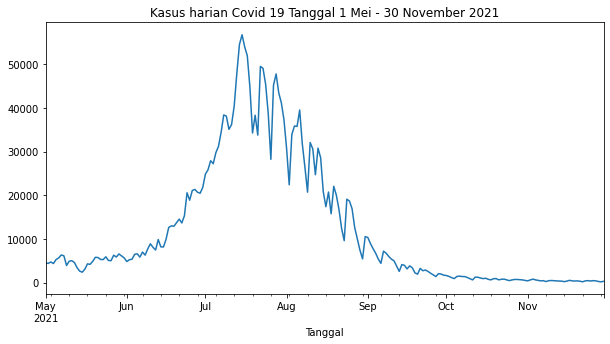

In [37]:
# Grafik kasus harian
df.set_index('Tanggal')['Kasus_harian'].plot(figsize=(10,5))
plt.title("Kasus harian Covid 19 Tanggal 1 Mei - 30 November 2021");

In [6]:
# melihat detail dari dataset
df.describe()

,Kasus_harian,Total_kasus,Kasus_aktif,Sembuh_baru,Sembuh,Meninggal_baru,Meninggal_Dunia
count,214.000000,2.140000e+02,214.000000,214.000000,2.140000e+02,214.000000,214.000000
mean,12093.649533,3.278471e+06,169914.158879,12065.528037,3.006087e+06,459.387850,102469.242991
std,14412.023174,1.037133e+06,174378.220592,13341.916355,1.040843e+06,541.600743,40273.090714
min,176.000000,1.672880e+06,7916.000000,260.000000,1.526978e+06,1.000000,45652.000000
25%,1240.000000,2.038564e+06,26100.000000,2289.250000,1.819603e+06,65.250000,55682.750000
50%,5419.500000,3.863046e+06,99375.000000,5887.000000,3.366922e+06,188.000000,118210.500000
75%,20351.250000,4.225525e+06,265073.500000,17516.750000,4.056882e+06,673.250000,142543.500000
max,56757.000000,4.256409e+06,574135.000000,48832.000000,4.104657e+06,2069.000000,143830.000000


# 3. Modelling

Metode yang digunakan untuk memprediksi jumlah kasus harian adalah regresi. Urutan kasus yang telah terjadi selama 'n' hari akan menjadi patokan dalam memprediksi jumlah kasus harian baru.

In [7]:
# fungsi untuk mengubah data aktual menjadi urutan data
def series_to_supervised(data, n_in, dropnan=True):
    df = pd.DataFrame(data)
    
    cols = []
    for i in range(n_in, -1, -1):
        cols.append(df.shift(i))
    df = pd.concat(cols, axis=1)
    
    if dropnan:
        df.dropna(inplace=True)
    return df.values

In [8]:
# penggunaan fungsi ke dalam data aktual
used = series_to_supervised(df['Kasus_harian'],10)

In [15]:
# hasil transformasi data
used[0]

array([4512., 4394., 4730., 4369., 5285., 5647., 6327., 6130., 3922.,
       4891., 5021.])

Terlihat bahwa data per hari diubah menjadi jumlah kasus harian berdasarkan tanggal selama 10 hari yang telah diurutkan.

In [16]:
# menentukan jumlah data uji dengan test size 20%
used.shape[0]*0.2

40.800000000000004

In [17]:
# membagi data latih dan data uji
train = used[:-41,:]
test = used[-41:,:]

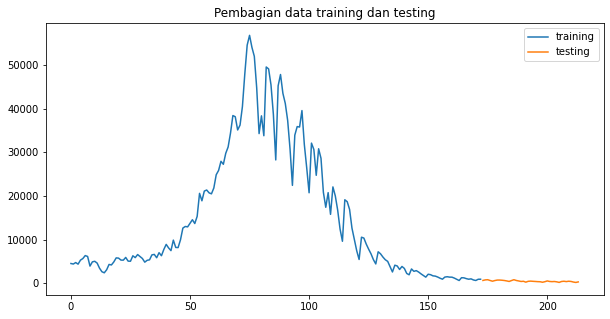

In [36]:
# visualisasi pembagian data latih dan data uji
plt.figure(figsize=(10,5))
plt.plot(df['Kasus_harian'][:-41], label='training')
plt.plot(df['Kasus_harian'][-41:], label='testing')
plt.title('Pembagian data training dan testing')
plt.legend();

In [19]:
# membagi data training menjadi variabel X dan Y
predictions = []
history = [x for x in train]

train = np.asarray(history)
X_train, y_train = train[:, :-1], train[:, -1]

In [20]:
# pembuatan model
model_RF = RandomForestRegressor(random_state=42)
model_DT = DecisionTreeRegressor(random_state=42)

In [21]:
# pelatihan model
model_RF.fit(X_train, y_train)
model_DT.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [22]:
# pengujian model menggunakan data testing
pred_RF = []
pred_DT = []

for i in range(len(test)):
    X_test = np.asarray([test[i, :-1]])
    
    y_pred_RF = model_RF.predict(X_test)
    y_pred_DT = model_DT.predict(X_test)
    
    pred_RF.append(y_pred_RF)
    pred_DT.append(y_pred_DT)

In [23]:
# Variabel y hasil uji
y_test = test[:, -1]

In [25]:
# evaluasi model
print('MAE dari Random Forest :', mean_absolute_error(y_test, pred_RF))
print('MAE dari Decision Tree :', mean_absolute_error(y_test, pred_DT))

MAE dari Random Forest : 271.25219512195116
MAE dari Decision Tree : 203.73170731707316


Model decision tree memiliki hasil yang lebih akurat, sehingga model ini akan digunakan untuk prediksi.

# 4. Forecast

In [26]:
# mengubah data aktual kasus harian menjadi urutan kasus
case = df['Kasus_harian'].values
case_value = series_to_supervised(case, n_in=14)

In [27]:
# membagi data aktual menjadi variabel X dan Y
x_train, y_train = case_value[:, :-1], case_value[:, -1]

In [28]:
# pembuatan model
forecast_DT = DecisionTreeRegressor()
forecast_DT.fit(x_train, y_train)

DecisionTreeRegressor()

In [29]:
# prediksi kasus
forecast = []
nilai = list(case)

for i in range(14):
    row = (nilai[-14:])
    pred = forecast_DT.predict([row])
    
    nilai.append(pred)
    forecast.append(pred[0])
print('Selesai')

Selesai


In [30]:
# mengecek tanggal terakhir kasus aktual
df.tail()

,Tanggal,Kasus_harian,Total_kasus,Kasus_aktif,Sembuh_baru,Sembuh,Meninggal_baru,Meninggal_Dunia
209,2021-11-26,453,4255268,8093,386,4103379,14,143796
210,2021-11-27,404,4255672,8226,260,4103639,11,143807
211,2021-11-28,264,4255936,8214,275,4103914,1,143808
212,2021-11-29,176,4256112,7960,419,4104333,11,143819
213,2021-11-30,297,4256409,7922,324,4104657,11,143830


In [31]:
# membuat urutan 14 hari setelah tanggal terakhir kasus aktual
tanggal_prediksi = pd.date_range('1/12/2021', periods=14)
df_forecast = pd.DataFrame({
    'Tanggal' : tanggal_prediksi,
    'Kasus_harian': forecast
})

In [32]:
# hasil prediksi
df_forecast

,Tanggal,Kasus_harian
0,2021-01-12,186.0
1,2021-01-13,372.0
2,2021-01-14,522.0
3,2021-01-15,404.0
4,2021-01-16,453.0
5,2021-01-17,404.0
6,2021-01-18,297.0
7,2021-01-19,186.0
8,2021-01-20,297.0
9,2021-01-21,451.0


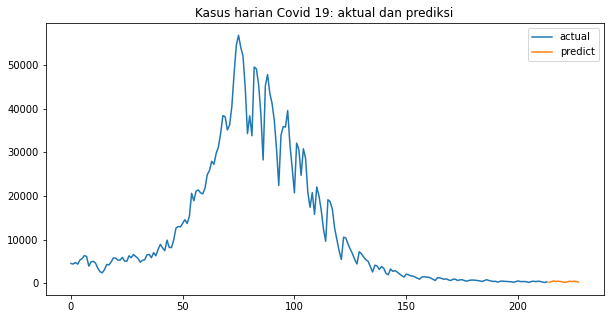

In [39]:
# grafik data aktual dan 
c = df.append(df_forecast).reset_index(drop=True)
plt.figure(figsize=(10,5))
c['Kasus_harian'][:-14].plot(label='actual')
c['Kasus_harian'][-14:].plot(label='predict')
plt.title('Kasus harian Covid 19: aktual dan prediksi')
plt.legend();

In [34]:
# ringkasan prediksi kasus
df_forecast.describe()

,Kasus_harian
count,14.000000
mean,361.142857
std,101.532001
min,186.000000
25%,297.000000
50%,388.000000
75%,434.000000
max,522.000000


**Analisis**

Diperkirakan jumlah kasus baru covid di Indonesia pada 1-14 Des 2021 (213 hari setelah 1 Mei) akan mengikuti pola kasus sejak sebulan sebelumnya. Diperikaran tidak ada perubahan signifikan pada jumlah kasus harian, dengan rata-rata 361 kasus minimal 186 kasus dan kasus tertinggi pada angka 522. 

Prediksi ini memiliki asumsi bahwa tidak adanya *outbreak* mendadak dan masuknya varian baru.